<a href="https://colab.research.google.com/github/evelyn023/COMP551-Machine-Learning/blob/main/LFM360_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# data cleaning

In [ ]:
inter_file = '/content/drive/MyDrive/datasets/lfm360k/LastFM360k-Le75.txt'
item_file = '/content/drive/MyDrive/datasets/lfm360k/LastFM360k-MB-artists.txt'
user_file = '/content/drive/MyDrive/datasets/lfm360k/usersha1-profile.tsv'

item_data0 = pd.read_csv(item_file, delimiter='\t', header=None, engine='python')
inter_data0 = pd.read_csv(inter_file, delimiter=',', header=[0], engine='python')
user_data0 = pd.read_csv(user_file, delimiter='\t', header=None, engine='python')

In [ ]:
item_data = item_data0.copy()
inter_data = inter_data0.copy()
user_data = user_data0.copy()

user_data.columns = ['id','gender','age','country','signup']
user_data.id = user_data.index
item_data = item_data.drop([3],axis=1)
item_data.columns = ['id','name','score']

In [ ]:
# user
userid_inter = np.unique(inter_data.userid.to_numpy())
user_data = user_data.loc[user_data.id.isin(userid_inter)]

signup = user_data.signup.str.split(pat=' |,').to_numpy()
signup2 = []

for i in range(signup.shape[0]):
  s = signup[i]
  if s[0] == 'Jan':
    ss = s[3]+'01'+s[1]
  elif s[0] == 'Feb':
    ss = s[3]+'02'+s[1]
  elif s[0] == 'Mar':
    ss = s[3]+'03'+s[1]
  elif s[0] == 'Apr':
    ss = s[3]+'04'+s[1]
  elif s[0] == 'May':
    ss = s[3]+'05'+s[1]
  elif s[0] == 'Jun':
    ss = s[3]+'06'+s[1]
  elif s[0] == 'Jul':
    ss = s[3]+'07'+s[1]
  elif s[0] == 'Aug':
    ss = s[3]+'08'+s[1]
  elif s[0] == 'Sep':
    ss = s[3]+'09'+s[1]
  elif s[0] == 'Oct':
    ss = s[3]+'10'+s[1]
  elif s[0] == 'Nov':
    ss = s[3]+'11'+s[1]
  else:
    ss = s[3]+'12'+s[1]
  if len(ss) != 8:
    ss = ss[:6]+'0'+ss[-1]
  signup2.append(ss)
user_data.signup = signup2

# user_data.loc[user_data.gender.isin(['f']),'gender'] = 0
# user_data.loc[user_data.gender.isin(['m']),'gender'] = 1
user_data.head(5)

,id,gender,age,country,signup
0,0,f,22.0,Germany,20070201
9,9,m,NaN,Ukraine,20080817
10,10,m,27.0,Sweden,20070105
12,12,NaN,NaN,Japan,20081013
14,14,f,NaN,Australia,20080726


In [ ]:
# item
artistid_inter = np.unique(inter_data.artistid.to_numpy())
item_data.score = item_data.score.str.split(pat='/')
item_data = item_data.sort_values(by=['id'], ignore_index=True)
item_data = item_data.loc[item_data.id.isin(artistid_inter)]

# total playcounts for each artist
artist_playcount = np.bincount(inter_data.artistid, weights=inter_data.playcount)
item_data['totalplays'] = np.zeros(item_data.shape[0])
for i in range(artist_playcount.shape[0]):
  p = artist_playcount[i]
  if p != 0:
    item_data.loc[item_data['id']==i, 'totalplays'] = p

score = item_data.score.to_numpy()
score_array = []
for s in score:
  g = np.argmax(s)
  if s[1] == s[2] or g==0 or g == 3 or g == 4:
    gender = 2
  elif g == 1:
    gender = 0
  elif g == 2:
    gender = 1
  score_array.append(gender)

# 0-male, 1-female, 2-unknown
item_data = item_data.drop(['score'],axis=1)
item_data['gender'] = score_array

item_data.head(5)

,id,name,totalplays,gender
0,0,betty blowtorch,11382.0,1
1,1,die Ärzte,1099058.0,0
2,2,melissa etheridge,8713.0,1
3,3,elvenking,277451.0,2
4,4,juliette & the licks,21033.0,2


In [ ]:
count = np.bincount(np.array(item_data['gender']))

print('number of users', userid_inter.shape)
print('number of artists', artistid_inter.shape)
print('number of interactions', inter_data.shape)
print('gender count:', count)

number of users (137157,)
number of artists (201096,)
number of interactions (6541600, 3)
gender count: [ 50087  10594 140415]


# sampling

In [ ]:
inter_file = '/content/drive/MyDrive/datasets/lfm360k/lfm360k.inter'
item_file = '/content/drive/MyDrive/datasets/lfm360k/lfm360k.item'
user_file = '/content/drive/MyDrive/datasets/lfm360k/lfm360k.user'

inter_data = pd.read_csv(inter_file, delimiter='\t', header=[0], engine='python')
inter_data.columns = ['userid','artistid','play']
item_data = pd.read_csv(item_file, delimiter='\t', header=[0], engine='python')
item_data.columns = ['id','name','totalplays','gender']
user_data = pd.read_csv(user_file, delimiter='\t', header=[0], engine='python')
user_data.columns = ['id','gender','age','country','signup']

In [ ]:
item_gender = item_data.loc[item_data['gender'].isin([1,0])]
print(item_gender.shape)
inter_gender = inter_data.loc[inter_data.artistid.isin(item_gender.id.to_numpy())]
print(inter_gender.shape)

(34034, 4)
(587463, 3)


In [ ]:
import math
np.random.seed(1234)

# ratio is male/female
def control_gender_ratio(ratio, male, female):
  num_female = female.shape[0]
  num_male = male.shape[0]

  if math.ceil(num_female*ratio) > num_male:
    num_female = math.ceil(num_male/ratio)
  else: 
    num_male = math.ceil(num_female*ratio)

  # sample
  sample_male_id = np.random.choice(male.id.to_numpy(), num_male, replace=False)
  sample_female_id = np.random.choice(female.id.to_numpy(), num_female, replace=False)


  return sample_male_id, sample_female_id


def sample(inter, item, user, num):
  u = np.unique(inter.userid.to_numpy())
  userid_sample = np.random.choice(u, num, replace=False)
  user_sample = user.loc[user.id.isin(userid_sample)]
  inter_sample = inter.loc[inter.userid.isin(userid_sample)]
  artistid = np.unique(inter_sample.artistid.to_numpy())
  item_sample = item.loc[item.id.isin(artistid)]
  #count = np.bincount(np.array(item_sample['gender']))
  
  print('users in sample', userid_sample.shape)
  print('item in sample:', item_sample.shape)
  print('interactions in sample', inter_sample.shape)

  return inter_sample, item_sample, user_sample


# get male and female artists data seperately
# male = item_data.loc[item_data.gender==0]
# female = item_data.loc[item_data.gender==1]
# nogender = item_data.loc[item_data.gender==2]

In [ ]:
inter_sample, item_sample, user_sample = sample(inter_data, item_data, user_data, 20000)

users in sample (20000,)
item in sample: (87750, 4)
interactions in sample (953032, 3)


In [ ]:
item_sample.describe()

,id,totalplays,gender
count,87750.000000,8.775000e+04,87750.000000
mean,81693.065128,1.587100e+04,1.286860
std,70684.744577,1.003590e+05,0.924747
min,0.000000,1.000000e+00,0.000000
25%,25700.500000,2.400000e+02,0.000000
50%,61056.500000,1.119500e+03,2.000000
75%,118976.750000,4.783000e+03,2.000000
max,292466.000000,6.165826e+06,2.000000


<function matplotlib.pyplot.show>

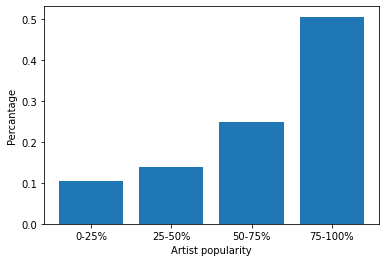

In [ ]:
x1 = 5.6e+01
x2 = 2.3e+02
x3 = 1.08e+03

plays= item_sample.totalplays.to_numpy()
p1 = np.count_nonzero(plays <= x1)
p2 = np.count_nonzero((plays > x1) & (plays <= x2))
p3 = np.count_nonzero((plays > x2) & (plays <= x3))
p4 = np.count_nonzero(plays > x3)

dist = np.array([p1,p2,p3,p4])/item_sample.shape[0]
plt.bar(["0-25%","25-50%","50-75%","75-100%"], dist)
plt.xlabel('Artist popularity')
plt.ylabel('Percantage')
plt.show

<function matplotlib.pyplot.show>

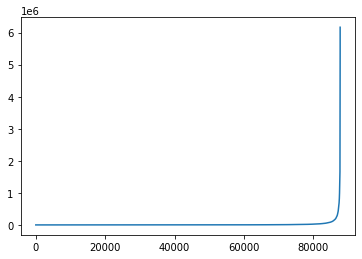

In [ ]:
plt.plot(range(plays.shape[0]), np.sort(plays))
plt.show

## control gender ratio in dataset

In [ ]:
# get artists id 
male_28, female_28 = control_gender_ratio(2/8, male, female)
male_55, female_55 = control_gender_ratio(1, male, female)
male_82, female_82 = control_gender_ratio(8/2, male, female)
male_91, female_91 = control_gender_ratio(9, male, female)
nogender = nogender.id.to_numpy()

a_28 = np.concatenate((male_28, female_28, nogender), axis = None)
a_55 = np.concatenate((male_55, female_55, nogender), axis = None)
a_82 = np.concatenate((male_82, female_82, nogender), axis = None)
a_91 = np.concatenate((male_91, female_91, nogender), axis = None)

inter_28 = inter_data.loc[inter_data.artistid.isin(a_28)]
inter_55 = inter_data.loc[inter_data.artistid.isin(a_55)]
inter_82 = inter_data.loc[inter_data.artistid.isin(a_82)]
inter_91 = inter_data.loc[inter_data.artistid.isin(a_91)]

In [ ]:
inter28_sample, item28_sample = sample(inter_28, item_data, 30000)
inter55_sample, item55_sample = sample(inter_55, item_data, 30000)
inter82_sample, item82_sample = sample(inter_82, item_data, 30000)
inter91_sample, item91_sample = sample(inter_91, item_data, 30000)


#users in sample (30000,)
#interactions in sample (682901, 3)
gender count in sample: [66264  1676  6409]


#users in sample (30000,)
#interactions in sample (800516, 3)
gender count in sample: [66575  6922  6488]


#users in sample (30000,)
#interactions in sample (1318961, 3)
gender count in sample: [66234 27689  6372]


#users in sample (30000,)
#interactions in sample (1386925, 3)
gender count in sample: [66480 32675  3363]




# gender analysis in control set

In [ ]:
# count total plays for male and female
artist_has_gender = item55_sample.loc[item55_sample['gender'].isin([1,0])]
number = np.bincount(artist_has_gender.gender)[:1] 
plays = np.bincount(artist_has_gender.gender, weights = artist_has_gender.totalplays)[:1]
# 0-male, 1-female
print('number of detected artists:', artist_has_gender.shape[0])
print('gender distribution by number:', number/number.sum())
print('gender distribution by playcounts:', plays/plays.sum())


number of detected artists: 13410
gender distribution by number: [0.51618195 0.48381805]
gender distribution by playcounts: [0.66779539 0.33220461]
gender distribution in top100: [70 30]


<function matplotlib.pyplot.show>

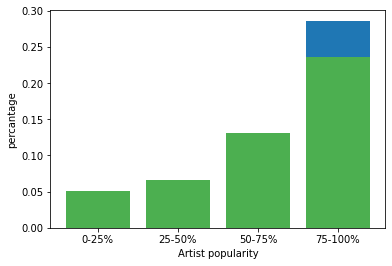

In [ ]:
x1 = 5.6e+01
x2 = 2.3e+02
x3 = 1.08e+03

p = artist_has_gender.totalplays.to_numpy()
p_male = artist_has_gender.loc[artist_has_gender.gender==0].totalplays.to_numpy()
p1 = np.count_nonzero(p_male <= x1)
p2 = np.count_nonzero((p_male > x1) & (p_male <= x2))
p3 = np.count_nonzero((p_male > x2) & (p_male <= x3))
p4 = np.count_nonzero(p_male > x3)

p_female = artist_has_gender.loc[artist_has_gender.gender==1].totalplays.to_numpy()
p11 = np.count_nonzero(p_female <= x1)
p21 = np.count_nonzero((p_female > x1) & (p_female <= x2))
p31 = np.count_nonzero((p_female > x2) & (p_female <= x3))
p41 = np.count_nonzero(p_female > x3)

dist_m = np.array([p1,p2,p3,p4])/artist_has_gender.shape[0]
dist_f = np.array([p11,p21,p31,p41])/artist_has_gender.shape[0]
plt.bar(["0-25%","25-50%","50-75%","75-100%"], dist_m)
plt.bar(["0-25%","25-50%","50-75%","75-100%"], dist_f, color="#4CAF50")
plt.xlabel('Artist popularity')
plt.ylabel('percantage')
plt.legend(["Male","Female"])
plt.show


# convert file

In [ ]:
import os
from tqdm import tqdm

def convert(input_data, selected_fields, output_file):
    output_data = pd.DataFrame()
    for column in selected_fields:
        output_data[column] = input_data.iloc[:, column]
    with open(output_file, 'w') as fp:
        fp.write('\t'.join([selected_fields[column] for column in output_data.columns]) + '\n')
        for i in tqdm(range(output_data.shape[0])):
            fp.write('\t'.join([str(output_data.iloc[i, j])
                                for j in range(output_data.shape[1])]) + '\n')

In [ ]:
output_inter_file = '/content/drive/MyDrive/datasets/lfm360k/lfm360k.inter'
output_item_file = '/content/drive/MyDrive/datasets/lfm360k/lfm360k.item'
output_user_file = '/content/drive/MyDrive/datasets/lfm360k/lfm360k.user'

inter_fields = {0: 'user_id:token', 
                1: 'artist_id:token', 
                2: 'plays:float'}

item_fields = {0: 'artist_id:token',
               1: 'name:token_seq', 
               2: 'totalplays:float',
               3: 'artist_gender:token'}

user_fields = {0:'user_id:token', 
               1:'gender:token', 
               2:'age:float', 
               3:'country:token_seq', 
               4:'signup:token'}

In [ ]:
item_data.head(10)

,id,name,totalplays,gender
0,0,betty blowtorch,11382.0,1
1,1,die Ärzte,1099058.0,0
2,2,melissa etheridge,8713.0,1
3,3,elvenking,277451.0,2
4,4,juliette & the licks,21033.0,2
5,5,red hot chili peppers,2625730.0,0
6,6,magica,25564.0,2
7,7,the black dahlia murder,761480.0,0
8,8,the murmurs,14894.0,2
9,9,lunachicks,36861.0,2


In [ ]:
user_data.shape

(20000, 5)

In [ ]:
convert(inter_gender, inter_fields, output_inter_file)

100%|██████████| 587463/587463 [00:55<00:00, 10493.90it/s]
